In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='whitegrid')
sns.plotting_context(context='paper')
sns.set_palette('rainbow')

import pickle
import pandas as pd

In [30]:
sales = pd.read_csv('../../../data/mckinsey/sales.csv', index_col='ID')
skus = pd.read_csv('../../../data/mckinsey/sku.csv', index_col='SKU')

covid_response = pd.read_excel('../../../data/oxford/OxCGRT_timeseries_all.xlsx')

sales = sales.join(skus, on='SKU')

sales['date'] = pd.to_datetime(sales['date'])
sales = sales.loc[sales['date'] > '2020-04-01']

sales_to_predict = pd.read_csv('../../../data/mckinsey/test.csv', index_col='ID')
sales_to_predict['date'] = pd.to_datetime(sales_to_predict['date'])
sales.fillna(1, inplace=True)

In [31]:
timeframe = pd.date_range(start=sales['date'].min(), end=sales['date'].max(), freq='D')

In [32]:
additional_clusters_added = sales.groupby('geoCluster')['date'].min().reset_index().groupby('date')['geoCluster'].count()
geoclusters_cumsum = additional_clusters_added.reindex(timeframe, fill_value=0).cumsum()

avg_covid_response = covid_response.select_dtypes('number').mean()
avg_covid_response.index = pd.to_datetime(avg_covid_response.index)

In [33]:
sku_daily_sales = sales.groupby('SKU').apply(lambda x: x.groupby('date')['sales'].sum().reindex(timeframe, fill_value=0)).transpose()

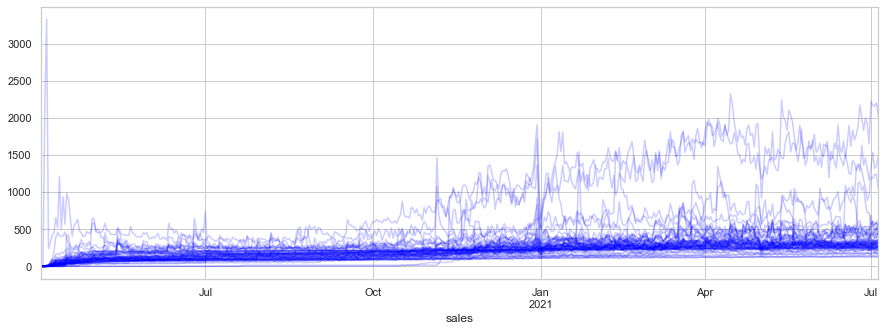

In [34]:
fig, ax = plt.subplots(figsize=(15, 5))

sku_daily_sales.plot(ax=ax, alpha=0.2, color='blue')
ax.get_legend().remove()

#### Seperate models for each SKU

In [35]:
with open('../../../data/sku_price_histories.pickle', 'rb') as handle:
    price_histories = pickle.load(handle)

In [38]:
import neuralprophet

skus = sales['SKU'].unique()

models = {}

for sku in skus:
    sku_sales = sales[sales['SKU'] == sku].copy()
    sku_sales = sku_sales.groupby('date')['sales'].sum().reindex(timeframe, fill_value=0).reset_index()

    sku_sales.rename(columns={'index': 'ds', 'sales': 'y'}, inplace=True)

    model = neuralprophet.NeuralProphet()
    model.add_country_holidays(country_name='US', lower_window=-2, upper_window=2)

    model.add_future_regressor('covid_response')
    model.add_future_regressor('active_geoclusters')
    model.add_future_regressor('price')

    sku_sales = sku_sales.join(avg_covid_response.rename('covid_response'), on='ds')
    sku_sales = sku_sales.join(geoclusters_cumsum.rename('active_geoclusters'), on='ds')
    sku_sales = sku_sales.join(price_histories[sku], on='ds')

    model.fit(sku_sales)

    models[sku] = model

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.783% of the data.
INFO - (NP.df_utils._infer_frequency) - Dataframe freq automatically defined as D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.


ValueError: Unexpected column price in data

In [ ]:
with open('../../../data/sku_prediction_models.pickle', 'wb') as handle:
    pickle.dump(models, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
sku = 24

sales = sku_daily_sales[sku].reset_index().rename(columns={'sales': 'ds', sku: 'y'})

sales = sales.join(avg_covid_response.rename('covid_response'), on='ds')
sales = sales.join(geoclusters_cumsum.rename('active_geoclusters'), on='ds')

prediction = models[sku].predict(sales)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.783% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.783% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


<AxesSubplot:xlabel='ds'>

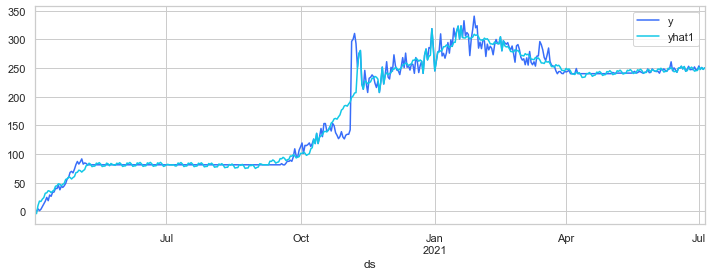

In [ ]:
fig, ax = plt.subplots(figsize=(12, 4))

prediction.plot(ax=ax, x='ds', y=['y', 'yhat1'])

#### Map predictions too test.csv

In [ ]:
prediction_validation_set = pd.read_csv('../../../data/mckinsey/test.csv', index_col='ID')
prediction_validation_set['date'] = pd.to_datetime(prediction_validation_set['date'])

In [ ]:
prediction_validation_set.loc[prediction_validation_set['SKU'] == 32485].sort_values('date')

,geoCluster,SKU,date,price_filled,sales
ID,,,,,
RR29287638,2114,32485,2021-07-06,41.29,NaN
RR28451109,2025,32485,2021-07-06,41.29,NaN
RR27964126,1297,32485,2021-07-06,39.69,NaN
RR31310812,3080,32485,2021-07-06,38.29,NaN
RR30766295,2510,32485,2021-07-06,43.99,NaN
...,...,...,...,...,...
RR30374671,2273,32485,2021-07-19,35.59,NaN
RR29228581,2105,32485,2021-07-19,35.59,NaN
RR29240318,2106,32485,2021-07-19,35.59,NaN


In [ ]:
sales.loc[sales['SKU'] == 32485]

KeyError: 'SKU'